# Example 4 (Advanced options): PEC of H$_{2}$ using Qiskit IBM Runtime Service.

In this section, we demonstrate how to use `qc2` alongside `Qiskit` and the `IBM Quantum Runtime Service` for calculating the potential energy curve of the hydrogen molecule. We utilize the `EstimatorV2` primitive as implemented in the `qiskit-ibm-runtime` package, in conjunction with the `ibmq_qasm_simulator`, to simulate a real quantum backend.

### Import required packages

In [1]:
import numpy as np

# ASE Atoms object
from ase import Atoms

# IBMQ runtime service packages
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    EstimatorV2 as Estimator,
    EstimatorOptions,
    Session
)

# Qiskit-related packages
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms.optimizers import COBYLA
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# ignore package import warnings
import warnings
warnings.filterwarnings('ignore')

# qc2 packages
from qc2.data import qc2Data
from qc2.ase import PySCF

### Initiate IBM runtime service

In the following steps, we assume that you have already created an __[IBM Quantum account](https://quantum.ibm.com/)__ and saved your accound credentials (via your personal token) on disk; for further info click __[here](https://github.com/Qiskit/qiskit-ibm-runtime/blob/main/README.md)__.

In [2]:
# instantiating `QiskitRuntimeService`
service = QiskitRuntimeService()

# run on simulator
backend = service.backend("ibmq_qasm_simulator")
# Use the following line if you want to run on a real quantum backend
# backend = service.least_busy(simulator=False)

options = EstimatorOptions()

# set seed for reproducible runs
options.seed_estimator = 42

# error supression options
options.optimization_level = 1

# error mitigation options
options.resilience_level = 0  # 2 = ZNE

# execution options
options.default_shots = 6000

# instantiate the Estimator to calculate expectation values
estimator = Estimator(backend=backend, options=options)

### Set up calculation details

In [3]:
# define activate space
n_active_electrons = (1, 1)
n_active_spatial_orbitals = 2

# define the type of fermionic-to-qubit transformation
mapper = JordanWignerMapper()

# define file to write the calculated data to
output_file = 'h2_pec_ibmq_qasm_simulator.data'
file = open(output_file, "w", encoding='utf-8')

# set up equilibrium geometry and initial circuit parameters in rads
req = 0.737166
req_params = [1.57079357, 1.57087253, 1.45852109]

# define vector of internuclear distances to loop over
r_distances = [r*req for r in np.arange(0.5, 5, 0.5)]

### Run VQE for each selected geometry

In [4]:
for r in r_distances:

    # set Atoms object
    mol = Atoms(
        'H2',
        positions=[[0.,  0.,  0.],
                   [0.,  0.,  r]]
    )

    # instantiate qc2Data class
    qc2data = qc2Data(
        molecule=mol,
        filename='h2.hdf5',
        schema='qcschema'
    )

    # specify the qchem calculator
    qc2data.molecule.calc = PySCF(method='scf.RHF', basis='sto-3g')

    # run calculation and save qchem data in the hdf5 file
    qc2data.run()

    # set up qubit Hamiltonian and core energy based on given activate space
    e_core, qubit_op = qc2data.get_qubit_hamiltonian(
        n_active_electrons,
        n_active_spatial_orbitals,
        mapper,
        format='qiskit'
    )

    # build up the initial quantum circuit
    reference_state = HartreeFock(
        n_active_spatial_orbitals,
        n_active_electrons,
        mapper,
    )

    # set up the ansatz using unitary CC as variational form
    ansatz = UCCSD(
        n_active_spatial_orbitals,
        n_active_electrons,
        mapper,
        initial_state=reference_state,
    )

    # create initial callback dictionary
    callback_dict = {
            "backend": None,
            "iters": 0,
            "cost_history": [],
            "parameters": [req_params],
            "gs_energy_history": [],
            "variance": []
    }

    def cost_func(params: list) -> float:
        """Return electronic energy from Estimator for given set of parameters.

        Args:
            params: list
                List of VQE parameters.

        Returns:
            energy: float
                Calculated electronic ground-state energy.
        """
        # perform transpilation
        pm = generate_preset_pass_manager(backend=backend, optimization_level=0)
        isa_circuit = pm.run(ansatz)
        isa_observable = qubit_op.apply_layout(isa_circuit.layout)

        # run job
        job = estimator.run(
            [(isa_circuit, isa_observable, params)]
        )
        result = job.result()
        energy = result[0].data.evs
        variance = result[0].data.stds
        parameters = list(params)

        callback_dict["iters"] += 1
        callback_dict["cost_history"].append(energy)
        callback_dict["backend"] = job.backend()
        callback_dict["gs_energy_history"].append(energy+e_core)
        callback_dict["variance"].append(variance)
        callback_dict["parameters"].append(parameters)

        # print intermediate data if needed
        # print("=== COST FUNCTION SUMMARY ===")
        # print(f">>> Job ID: {job.job_id()}")
        # print(f">>> Job Status: {job.status()}")
        # print("=============================")
        # print(f">>> Job Input: {job.inputs}")
        # print("=============================")
        # print(f">>> Backend: {job.backend()}")
        # print(f">>> {result}")
        # print("=============================")
        # print(f">>> Expectation value (Hartree): {energy}")
        # print(f">>> Total ground state energy (Hartree): {energy+e_core}")
        # print("=============================\n")
        return energy

    # initiate Qiskit Runtime Section
    with Session(service=service, backend=backend) as session:

        # initial circuit parameters
        initial_theta = np.array(callback_dict['parameters'][-1])

        # set up the classical optimizer
        optimizer = COBYLA(maxiter=300)
        
        # find the best circuit parameters that minimizes the electronic energy
        res = optimizer.minimize(
            cost_func,
            x0=initial_theta
        )
        print(f">>> Final ground state energy (hartree): {res.fun+e_core}\n")

        # write relevant data to file
        data_to_write = f"{r} {callback_dict['gs_energy_history'][-1]} " \
                        f"{callback_dict['variance'][-1]}\n"
        file.write(data_to_write)

        # use the optimized circuit parameters as guess for the next geometry
        req_params = callback_dict['parameters'][-1]

        session.close()

file.close()

* Reference energy (Hartree): -0.8323959925858835
* Saving qchem data in h2.hdf5

>>> Final ground state energy (hartree): -0.8366257350658743

* Reference energy (Hartree): -1.11690055771897
* Saving qchem data in h2.hdf5

>>> Final ground state energy (hartree): -1.1349489643349955

* Reference energy (Hartree): -1.0347677703871998
* Saving qchem data in h2.hdf5

>>> Final ground state energy (hartree): -1.0739508097501043

* Reference energy (Hartree): -0.9186044326889025
* Saving qchem data in h2.hdf5

>>> Final ground state energy (hartree): -1.0002826958494946

* Reference energy (Hartree): -0.8185133354304801
* Saving qchem data in h2.hdf5

>>> Final ground state energy (hartree): -0.9588193874386988

* Reference energy (Hartree): -0.7444704693706197
* Saving qchem data in h2.hdf5

>>> Final ground state energy (hartree): -0.939401703419809

* Reference energy (Hartree): -0.6935395490285441
* Saving qchem data in h2.hdf5

>>> Final ground state energy (hartree): -0.9350495720648

### Calculate PEC using PySCF for comparison

With our VQE points done, let's calculate the PEC using a classical qchem backend to compare with, but now using a finer grid of internuclear distances.

In [5]:
import numpy as np

import pyscf
from pyscf import gto, scf, fci

# set up equilibrium geometry and vector of internuclear distances
req = 0.737166
r_distances = [r*req for r in np.arange(0.5, 5, 0.05)]

# define file to write data to
output_file = 'pyscf_fci_sto3g_h2.data'

with open(output_file, "w", encoding='utf-8') as file:

    for r in r_distances:

        # run HF
        mol_h2 = gto.M(atom=f'H 0 0 0; H 0 0 {r}', basis='sto-3g', verbose=0)
        scf_h2 = scf.RHF(mol_h2)
        hf_energy = scf_h2.kernel()

        # run FCI
        hf_h2 = mol_h2.RHF().run()
        fci_energy = fci.FCI(hf_h2).kernel()[0]

        print(f'* Energy (hartree) {fci_energy:.6f} :: r (angstrom) {r:.3f}')

        # write data to file
        data_to_write = f"{r} {hf_energy} {fci_energy}\n"
        file.write(data_to_write)

* Energy (hartree) -0.841556 :: r (angstrom) 0.369
* Energy (hartree) -0.924999 :: r (angstrom) 0.405
* Energy (hartree) -0.987489 :: r (angstrom) 0.442
* Energy (hartree) -1.034243 :: r (angstrom) 0.479
* Energy (hartree) -1.068956 :: r (angstrom) 0.516
* Energy (hartree) -1.094322 :: r (angstrom) 0.553
* Energy (hartree) -1.112352 :: r (angstrom) 0.590
* Energy (hartree) -1.124586 :: r (angstrom) 0.627
* Energy (hartree) -1.132223 :: r (angstrom) 0.663
* Energy (hartree) -1.136210 :: r (angstrom) 0.700
* Energy (hartree) -1.137302 :: r (angstrom) 0.737
* Energy (hartree) -1.136103 :: r (angstrom) 0.774
* Energy (hartree) -1.133097 :: r (angstrom) 0.811
* Energy (hartree) -1.128672 :: r (angstrom) 0.848
* Energy (hartree) -1.123139 :: r (angstrom) 0.885
* Energy (hartree) -1.116748 :: r (angstrom) 0.921
* Energy (hartree) -1.109701 :: r (angstrom) 0.958
* Energy (hartree) -1.102166 :: r (angstrom) 0.995
* Energy (hartree) -1.094279 :: r (angstrom) 1.032
* Energy (hartree) -1.086157 ::

### Plot PECs

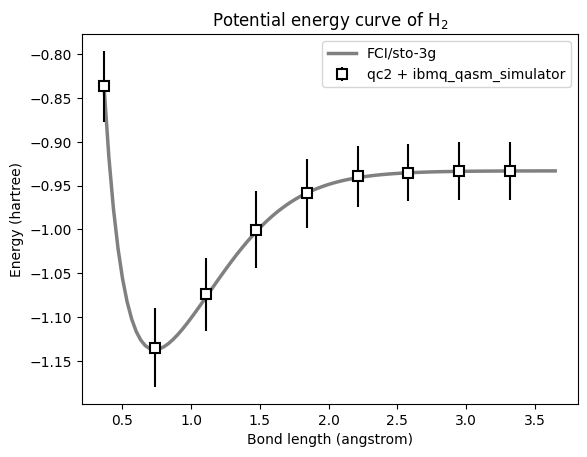

In [12]:
import numpy as np
from scipy.interpolate import splrep, splev
import matplotlib.pyplot as plt

# step 1: read the data from the file
data_pyscf = np.loadtxt('pyscf_fci_sto3g_h2.data')  #, skiprows=1)  # Assuming the first row is a header
data_ibmq = np.loadtxt('h2_pec_ibmq_qasm_simulator.data')

# extract the columns
r = data_pyscf[:, 0]
energy = data_pyscf[:, 2]

r_ibmq = data_ibmq[:, 0]
energy_ibmq = data_ibmq[:, 1]

# standard deviation 
std_ibmq = np.sqrt((data_ibmq[:, 2]))

# step 2: perform spline interpolation using SciPy
spline = splrep(r, energy, s=0)  # Adjust s for smoothing factor

# Evaluate the spline at more points for a smoother curve
r_interp = np.linspace(r.min(), r.max(), 100)
energy_interp = splev(r_interp, spline)

# step 3: plot the interpolated data using Matplotlib
plt.figure()
plt.plot(r_interp, energy_interp, label='FCI/sto-3g', linewidth=2.5, color='gray')

plt.errorbar(r_ibmq, energy_ibmq, std_ibmq, label='qc2 + ibmq_qasm_simulator',
             barsabove=False, ecolor='black', elinewidth=1.5,
             linestyle='None', marker='s', mfc='white',
             mec='black', ms=10*0.75, mew=2*0.75)

plt.xlabel('Bond length (angstrom)')
plt.ylabel('Energy (hartree)')
plt.title('Potential energy curve of H$_2$')
plt.legend()
plt.grid(False)
plt.show()